In [1]:
import matplotlib as mpl
import tensorflow as tf
%matplotlib inline
import numpy as np
import sklearn 
import os
import sys
import time
from tensorflow import keras
import pandas as pd
import matplotlib.pyplot as plt
print(tf.__version__)
print(sys.version_info)

for module in mpl,np,pd,sklearn,tf,keras:
    print(module.__name__,module.__version__)

2.0.0
sys.version_info(major=3, minor=7, micro=5, releaselevel='final', serial=0)
matplotlib 3.1.2
numpy 1.18.1
pandas 0.25.3
sklearn 0.22.1
tensorflow 2.0.0
tensorflow_core.keras 2.2.4-tf


In [2]:
fashion_mnist = keras.datasets.fashion_mnist
(x_train_all,y_train_all),(x_test,y_test) = fashion_mnist.load_data()

In [3]:
x_valid,x_train = x_train_all[:5000],x_train_all[5000:]
y_valid,y_train = y_train_all[:5000],y_train_all[5000:]
print(x_valid.shape,y_valid.shape)
print(x_train.shape,y_train.shape)
print(x_test.shape,y_test.shape)

(5000, 28, 28) (5000,)
(55000, 28, 28) (55000,)
(10000, 28, 28) (10000,)


In [4]:
#归一化，这里使用sklearn
#x = (x - u) / std
from sklearn.preprocessing import StandardScaler
std = StandardScaler()
#x_train:[None,28,28] -> [None,784]
x_train_scaled = std.fit_transform(x_train.astype(np.float32).reshape(-1,1)).reshape(-1,28,28)
x_valid_scaled = std.transform(x_valid.astype(np.float32).reshape(-1,1)).reshape(-1,28,28)
x_test_scaled =  std.transform(x_test.astype(np.float32).reshape(-1,1)).reshape(-1,28,28)

In [8]:
#tf.keras.model.Sequential()
# 深度神经网络
model = keras.models.Sequential()

model.add(keras.layers.Flatten(input_shape=[28,28]))
for _ in range(20):
    model.add(keras.layers.Dense(100,activation='selu'))#修改激活函数
#     model.add(keras.layers.BatchNormalization())#批归一化
# dropout主要是防止过拟合，一般在最后几层添加
model.add(keras.layers.AlphaDropout(rate=0.5))
# model.add(keras.layers.Dropout(rate=0.5))
#AlphaDropout: 1.均值和方差不变 2.归一化性质也不变     更加强大




model.add(keras.layers.Dense(10,activation='softmax'))

model.compile(loss = "sparse_categorical_crossentropy",
             optimizer="adam",
             metrics=["accuracy"])

In [9]:
model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
flatten_1 (Flatten)          (None, 784)               0         
_________________________________________________________________
dense_21 (Dense)             (None, 100)               78500     
_________________________________________________________________
dense_22 (Dense)             (None, 100)               10100     
_________________________________________________________________
dense_23 (Dense)             (None, 100)               10100     
_________________________________________________________________
dense_24 (Dense)             (None, 100)               10100     
_________________________________________________________________
dense_25 (Dense)             (None, 100)               10100     
_________________________________________________________________
dense_26 (Dense)             (None, 100)              

In [10]:
#使用三个回调函数 Tensorboard(文件夹),earlystopping,ModelCheckpoint(文件名)
logdir = os.path.join("dnn-selu-dropout-callbacks")
print(logdir)
if not os.path.exists(logdir):
    os.mkdir(logdir)
    
output_model_file = os.path.join(logdir,'fashion_mnist_model.h5')
callbacks = [
    keras.callbacks.TensorBoard(logdir),
    keras.callbacks.ModelCheckpoint(output_model_file,save_best_only = True),
    keras.callbacks.EarlyStopping(monitor='val_loss',patience= 5, min_delta=1e-3),
]  #定义一个数组


history = model.fit(x_train_scaled,y_train,epochs=10,validation_data=(x_valid_scaled,y_valid),callbacks=callbacks)

dnn-selu-dropout-callbacks
Train on 55000 samples, validate on 5000 samples
Epoch 1/10
55000/55000 [==============================] - 10s 183us/sample - loss: 0.8256 - accuracy: 0.7252 - val_loss: 0.9407 - val_accuracy: 0.8138
Epoch 2/10
55000/55000 [==============================] - 9s 158us/sample - loss: 0.6825 - accuracy: 0.7771 - val_loss: 0.7983 - val_accuracy: 0.8118
Epoch 3/10
55000/55000 [==============================] - 9s 158us/sample - loss: 0.5916 - accuracy: 0.8095 - val_loss: 0.7799 - val_accuracy: 0.8316
Epoch 4/10
55000/55000 [==============================] - 8s 150us/sample - loss: 0.5893 - accuracy: 0.8085 - val_loss: 0.8457 - val_accuracy: 0.8270
Epoch 5/10
55000/55000 [==============================] - 8s 148us/sample - loss: 0.6381 - accuracy: 0.7939 - val_loss: 0.8688 - val_accuracy: 0.8194
Epoch 6/10
55000/55000 [==============================] - 8s 150us/sample - loss: 0.6020 - accuracy: 0.8030 - val_loss: 0.9696 - val_accuracy: 0.8194
Epoch 7/10
55000/55000 

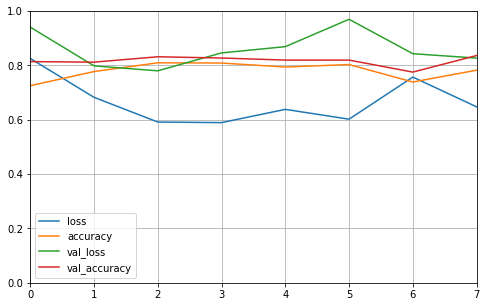

In [11]:
def plot_learning_curves(history):
    pd.DataFrame(history.history).plot(figsize=(8,5))
    plt.grid(True)
    plt.gca().set_ylim(0,1)
    plt.show()
    
plot_learning_curves(history)


# 1、参数众多，训练不充分
# 2、梯度消失 -> 链式法则 -> 复合函数f(g(x))
# 3、selu缓解梯度消失

In [12]:
model.evaluate(x_test_scaled,y_test)

10000/1 [===============================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================

[0.8564235029697418, 0.8158]